In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sys
sys.path.append("../")
from model import ConfigurableModel, ConfigurableModelWoBatchNormDropout
import logomaker
import os
from typing import Callable


##Loading Data Model from Saved Weight

In [ ]:
config = {"cnn_first_filter":16, "cnn_first_kernel_size":9, "cnn_length":3, "cnn_filter":64, "cnn_kernel_size":3, "bilstm_layer":3, "bilstm_hidden_size":128, "fc_size":64}
model = ConfigurableModelWoBatchNormDropout(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                                cnn_length=config["cnn_length"], cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                                output_size=1)
#fold
fold = 1
model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/analysis/new_param_wo_batchnorm/models/trained_model_{fold}th_fold_case_m6_info-no_promoter-False_TUNED_MODEL_wo_batchnorm_dropout_test_wo_m6A.pkl",
                          map_location=torch.device('cpu'))
model.load_state_dict(model_weight)
model.eval()

for k, v in model_weight.items():
    print(k)

In [11]:
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/wrapper")
from wrapper import utils
seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/single_model/case/motif_fasta_test_SPLIT_{fold}.fasta"
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

## Plot First CNN Layer Logo

In [12]:
def forward_to_RELU_1(model, x):
    for i, layer in enumerate(model.CNN): # Assuming there is defined "self.CNN" layer
        x = layer(x)
        if isinstance(layer, nn.ReLU): # If it reaches ReLU, return the output 
            break
    return x

model.eval()
with torch.no_grad():
    first_layer_result = forward_to_RELU_1(model, seq_fasta_one_hot)

kernel_size = model.CNN[0].kernel_size[0]

In [14]:
first_layer_result.shape

torch.Size([19136, 16, 497])

In [377]:
def activation_pfm(layer_output: torch.Tensor, one_hot_sequences: torch.Tensor, window: int=9, threshold: float=0.5) -> np.ndarray:
    """
    Compute the Position Frequency Matrix (PFM) from a given torch layer output and one-hot-encoded sequences. Details are explained on the DeepBind supplementary material (10.2 Sequence logos). 
    
    input: layer_output: torch.Tensor, shape: ([batch, seq_length_out, num_cnn_layers])
    input: one_hot_sequence: torch.Tensor, shape: ([batch, seq_length, 4])
    input: window: int, size of the activation window (default 9)
    input: threshold: float, threshold to consider an activation (default 0.5)

    return: PFM: np.array, shape: ([num_filter_layer_output, window, 4])
    """
    input = layer_output # ([batch, seq_length_out, num_cnn_layers])
    X = one_hot_sequences # ([batch, seq_length, 4])

    seq_length = X.shape[1]
    pfm = []
    window_left = int(window/2)
    window_right = window - window_left
    # Looping through all kernels -> np(batch,seq_length)
    for filter_index in range(input.shape[2]):
        x,y = np.where(input[:, :, filter_index] > threshold) # extract coordinates (sequence, position) which pass threshold
        sequences = set(x) # extract sequence which pass threshold
        if len(sequences)>0:
            max_indexes = np.argmax(input[list(sequences),:,filter_index], axis = 1) # extract max position for each sequence
            seq_align = []
            for seq_index, max_index in zip(sequences, max_indexes):
                start_window = int(max_index) - window_left
                end_window = int(max_index) + window_right

                # Create padding if out of bound
                if start_window < 0:
                    padding = np.zeros((-start_window, 4)) 
                    seq = np.concatenate([padding, X[seq_index, :end_window, :]], axis=0)
                elif end_window > seq_length:
                    padding = np.zeros((end_window - seq_length, 4))  
                    seq = np.concatenate([X[seq_index, start_window:, :], padding], axis=0)
                else:
                    seq = X[seq_index, start_window:end_window, :]
                seq_align.append(seq)
                
            if len(seq_align)>1:
                pfm.append(np.sum(seq_align, axis=0)) # create Position Frequency Matrix, summin over all sequences(batch)
            else:
                pfm.append(seq_align) 
        else:
            # If no sequence pass the threshold on a filter, add a zero matrix
            print("No sequence pass the threshold. Adding zero matrix")
            pfm.append(np.zeros((window, 4)))
            
    return np.array(pfm)

In [446]:
# need to transpose to have the right shape for pfm calculation
pfm = activation_pfm(first_layer_result.transpose(1,2).detach().cpu(),
                     seq_fasta_one_hot.transpose(1,2).detach().cpu(),
                     model.CNN[0].kernel_size[0], 1)
print(pfm.shape)

(10, 9, 4)


In [483]:
def plot_motifs_from_pfm(pfm: np.ndarray, out_dir: str, file_name: str, interactive: bool=True) -> None:
    """
    Plot motifs from Position Frequency Matrix.
    modified from https://github.com/p-koo/learning_sequence_motifs/blob/master/code/deepomics/visualize.py

    input: pfm: np.ndarray, shape: ([num_filter_layer_output, window, 4])
    input: out_dir: str, output directory
    input: file_name: str, output file name
    """
    fig = plt.figure(figsize=(30,10))
    fig.suptitle("Learned Motifs from The First Layer of CNN", fontsize=20)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    num_filters = pfm.shape[0]
    num_cols = 5
    num_rows = int(np.ceil(num_filters/num_cols))
    for n, f in enumerate(pfm):
        # f in [window.4] shape
        ax = fig.add_subplot(num_rows, num_cols, n+1)
        # IC is the information content
        # calculated from relative entropy: \sum{bases}p(a)log_{2}\frac{p(a), background_freq(a)}
        # which is the same as \sum{bases}p(a)log_{2}{p(a)} + log_{2}{4}, assuming a uniform background distribution 
        n_bases = 4
        pfm_sum = np.sum(f, axis=1, keepdims=True)
        ppm = f / pfm_sum # calculating PPM
        IC = np.log2(n_bases) + np.sum(ppm * np.log2(ppm+1e-8), axis=1, keepdims=True) # avoid log(0) by add small value
        logo = IC*ppm 

        counts_df = pd.DataFrame(data=logo, columns=list("ACGT"), index=list(range(L)))

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_ticks_position("none")
        plt.title(f"FILTER {n+1}")
        plt.xticks([])
        plt.yticks([])

    if interactive:
        plt.show()
    else:
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        outfile = os.path.join(out_dir, f"{file_name}.pdf")
        fig.savefig(outfile, format="pdf", dpi=200, bbox_inches="tight")
        plt.close(fig)

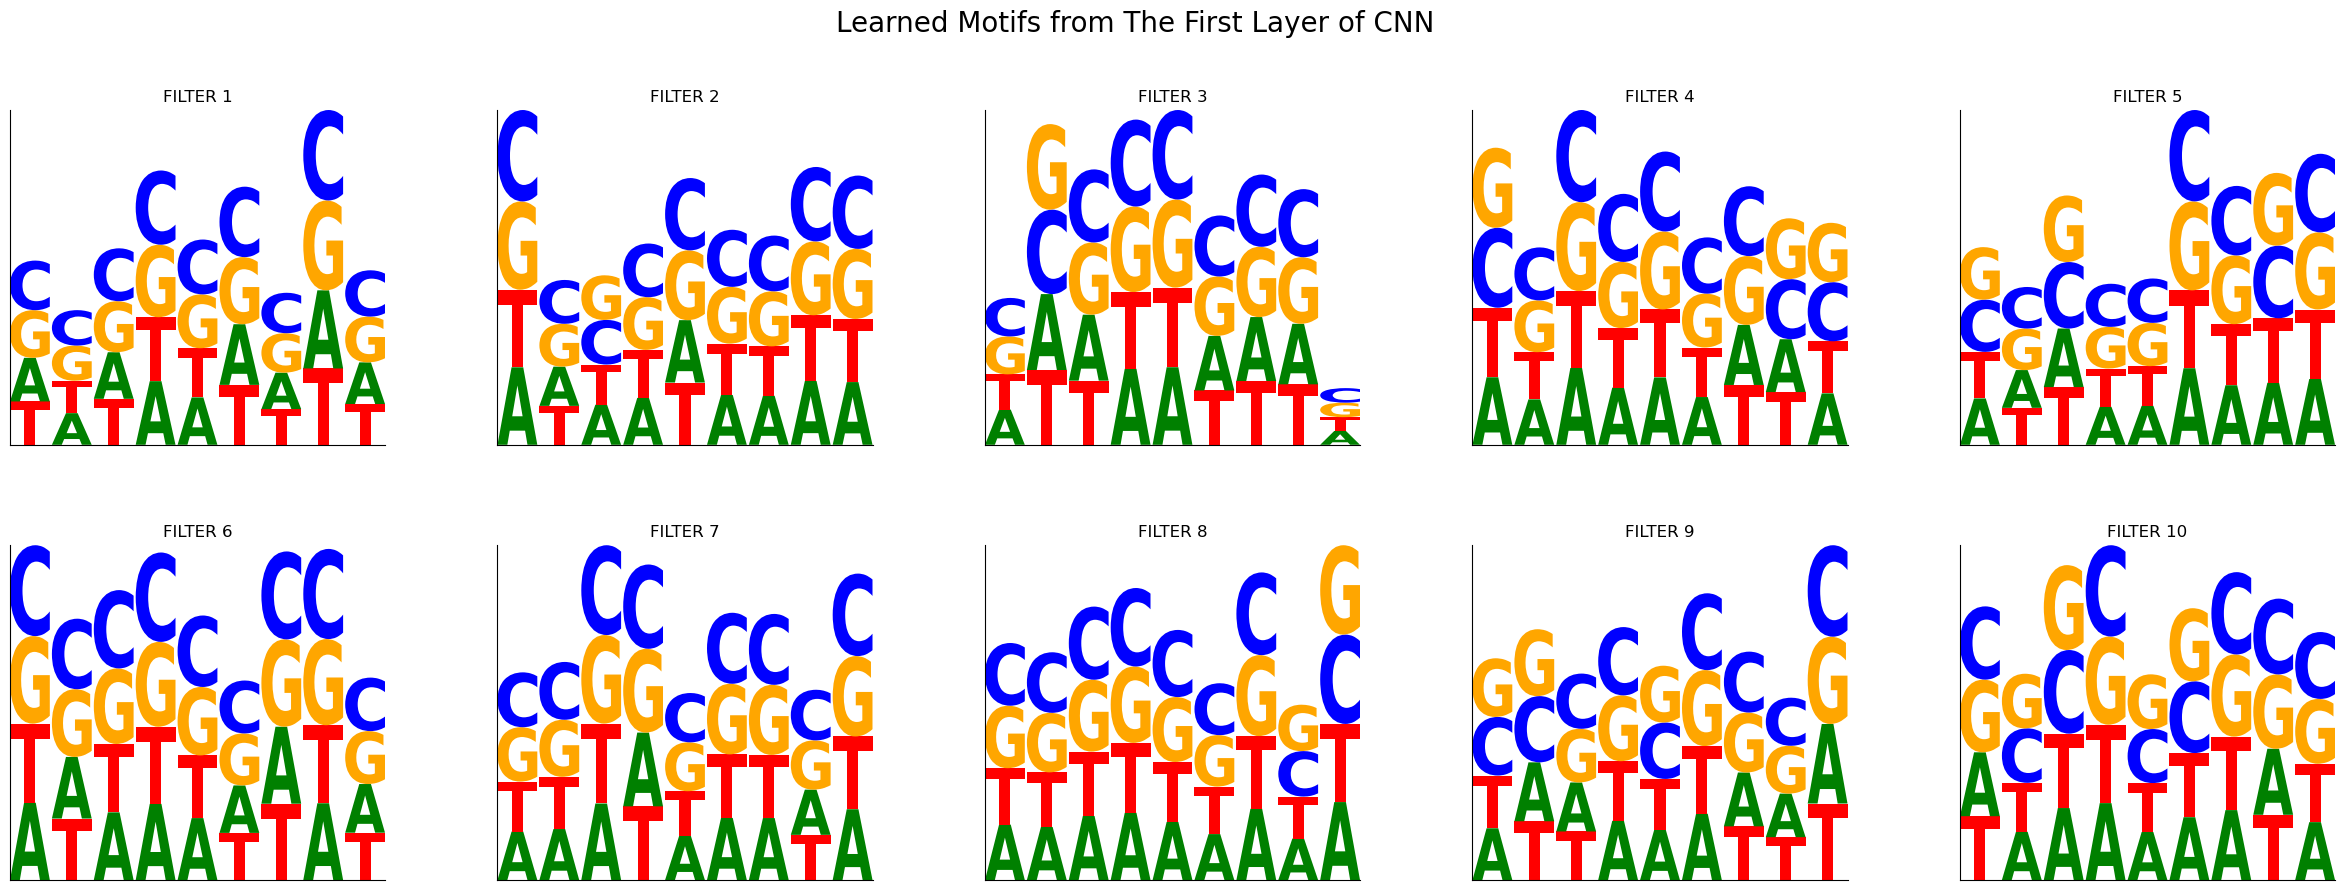

In [484]:
plot_motifs_from_pfm(pfm, "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/analysis", "test_logo", interactive=True)

## Plot Logo from Integrated Gradient 

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sys
sys.path.append("../")
from model import ConfigurableModel
import time
import logomaker
import os
from typing import Callable
import gc
from captum.attr import IntegratedGradients

config = {"cnn_first_filter": 10, "cnn_first_kernel_size": 9, "cnn_length": 2, "cnn_filter": 64, "cnn_kernel_size": 5, "bilstm_layer": 3, "bilstm_hidden_size": 64, "fc_size": 256}
model = ConfigurableModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                                cnn_length=config["cnn_length"], cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                                output_size=2)
#fold
fold = 1
model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_ONE_HOT_BEST_PARAM.pkl",
                          map_location=torch.device('cpu'))
model.load_state_dict(model_weight)
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/wrapper")
from wrapper import utils
seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)
meta_data_test_json_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
# Get 100 smalles MSE sequences from test set
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual

test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

pred= torch.Tensor().to("cpu", non_blocking=True)
true = torch.Tensor().to("cpu", non_blocking=True)

for data in test_loader:
    seq = data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([data[f"meth_control"].to(device, non_blocking=True), 
                                    data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    pred = torch.cat([pred, meth_true_val.cpu().detach()])
    true = torch.cat([true, meth_pred_val.cpu().detach()])

true_control = true[:,0]
true_case = true[:,1]
pred_control = pred[:,0]
pred_case = pred[:,1]

del pred, true
model.cpu()

control_mse = ((true_control - pred_control)**2)
_, ctrl_idx = torch.sort(control_mse, descending=False)
case_mse = ((true_case - pred_case)**2)
_, case_idx = torch.sort(case_mse, descending=False)
# Extracting top 100 sequences
top_100_ctrl = seq_fasta_one_hot[ctrl_idx[:100],:,:]
top_100_case = seq_fasta_one_hot[case_idx[:100],:,:]


In [36]:
def random_baseline_integrated_gradients(inputs: torch.Tensor, model: torch.nn.Module, index: int, steps: int, num_random_trials: int, cuda=True, batch=None) -> np.ndarray:
    """

    param: inputs: torch.Tensor: input tensor
    param: model: torch.nn.Module: model
    param: index: int: index of the target label (0 (control) or 1 (case))
    param: steps: int: Riemann approx for IG integral
    param: num_random_trials: int: number of random trials 
    param: cuda: bool: use cuda or not
    param: batch: int: batch size for internal batch size for captum IG
    return: np.ndarray: integrated gradients

    Can't process all due to memory and it is also not necessary to get the motif from low importance sequences
    === NOTES: EXPECTED ROUNDING DIFFERENT FOR SMALL NUMBER. PLEASE USE GPU FOR PERFORMANCE WISE ===
    """

    try:
        all_intgrads = []
        length = inputs.shape[-1]        # input shape [1,4,length]
        baseline = torch.FloatTensor(np.zeros(inputs.shape))
        model.eval()
        if cuda:
            # To enable backward for RNN in pytorch where device is GPU or CUDA. Known issue here: https://github.com/pytorch/captum/issues/564
            torch.backends.cudnn.enabled=False
            # Run dummy forward first 
            _ = model(torch.rand((1,4,1001)))
            # Hard coded device ids. should be changed to more general
            # model = nn.DataParallel(model.cuda(), device_ids=[0,1,2,3])
            # use all GPUs
            model = nn.DataParallel(model.cuda())
            baseline = baseline.to('cuda')
            inputs = inputs.to('cuda')
        else:
            model.cpu()
        for i in range(num_random_trials):
            ig = IntegratedGradients(model)
            integrated_grad = ig.attribute(inputs=inputs, internal_batch_size=batch, baselines=baseline, target=index, n_steps=steps)
            all_intgrads.append(integrated_grad.detach().cpu() if cuda else integrated_grad.detach())
            # print('the trial number is: {}'.format(i))
        avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    finally:
        if cuda:
            torch.cuda.empty_cache() 
            model.cpu() 
            del baseline
            del inputs
            gc.collect()
    return avg_intgrads

In [42]:
# Can't process all due to memory and it is also not necessary to get the motif from low importance sequences
# For 100 sequences it took ~1 minute
# # Index = 0 -> control
IG = random_baseline_integrated_gradients(inputs=top_100_ctrl, model=model, index=0, steps=50, num_random_trials=10)

plot_matrix = np.average(np.multiply(top_100_ctrl, IG), axis=0)
df = pd.DataFrame(plot_matrix.T, columns=list("ACGT"))

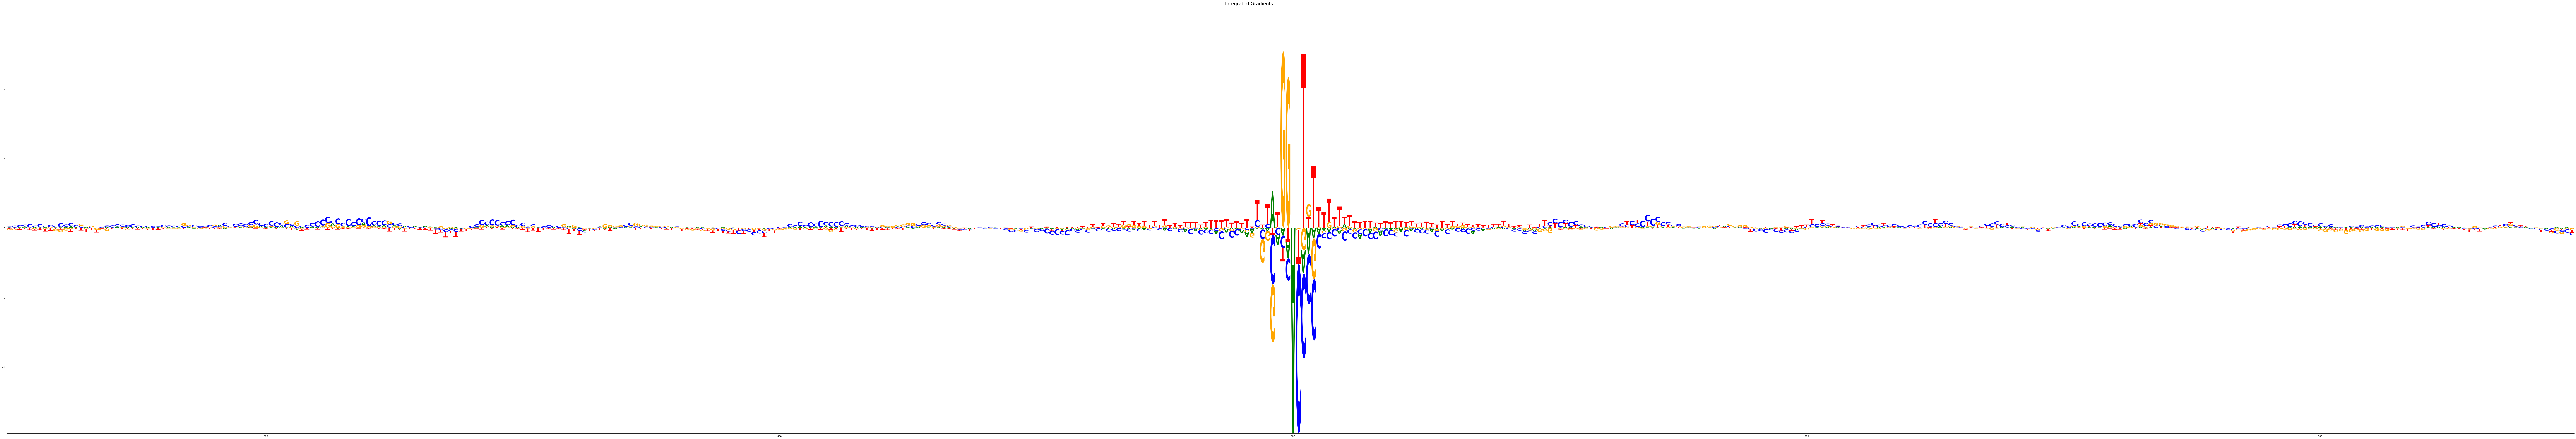

In [51]:
fig = plt.figure(figsize=(200,30))
fig.suptitle("Integrated Gradients Control", fontsize=20)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1, 1, 1)
logomaker.Logo(df.iloc[250:750,:], ax=ax, color_scheme='classic')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
plt.show()

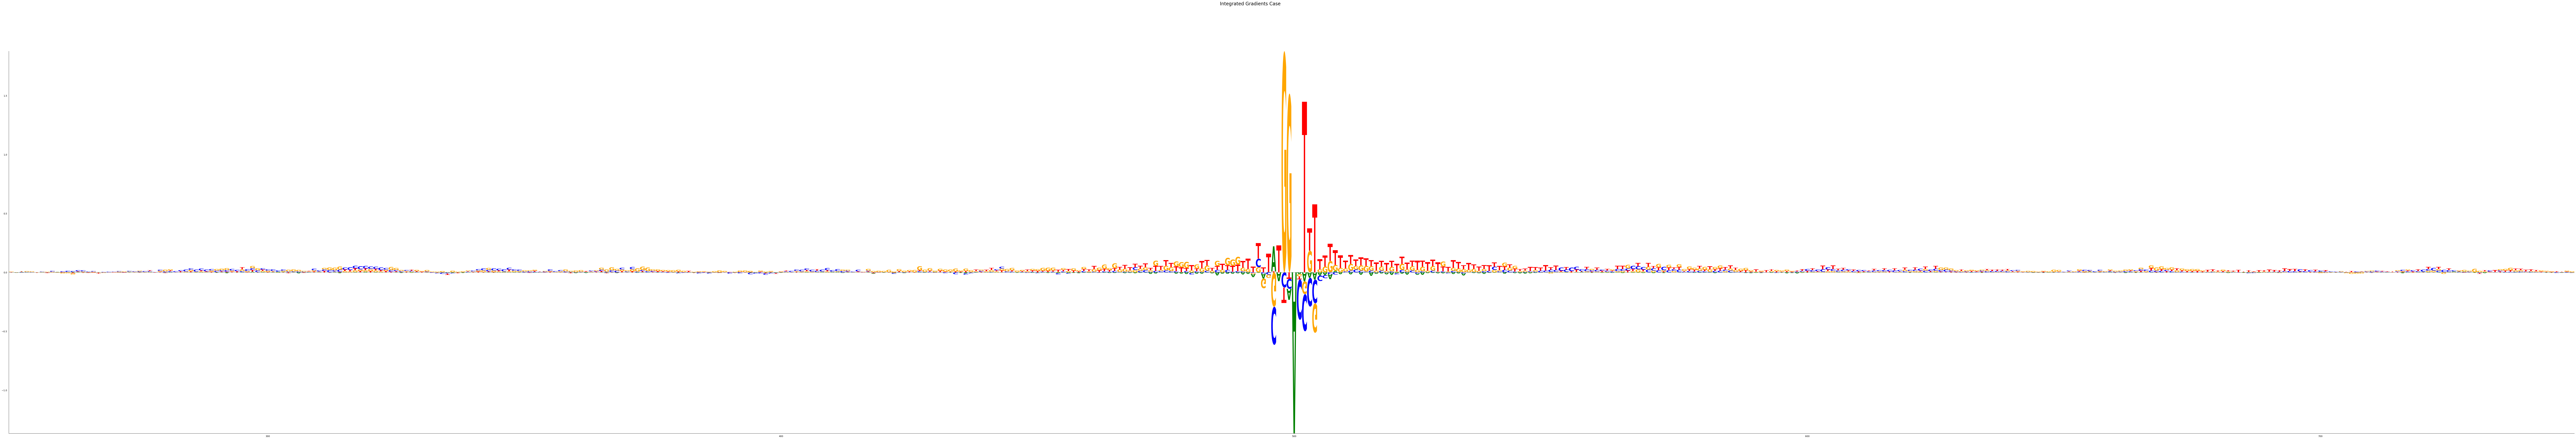

In [60]:
# Index = 1 -> case
# ~ 2 minutes
IG = random_baseline_integrated_gradients(inputs=top_100_case, model=model, index=1, steps=50, num_random_trials=10)

plot_matrix = np.average(np.multiply(top_100_case, IG), axis=0)
df = pd.DataFrame(plot_matrix.T, columns=list("ACGT"))
fig = plt.figure(figsize=(200,30))
fig.suptitle("Integrated Gradients Case", fontsize=20)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1, 1, 1)
logomaker.Logo(df.iloc[250:750,:], ax=ax, color_scheme='classic')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
plt.show()

In [38]:
ig_captum = random_baseline_integrated_gradients(inputs=seq_fasta_one_hot[:10,:,:], model=model, index=0, steps=50, num_random_trials=10)

In [40]:
def calculate_outputs_and_gradients(inputs, model, index,cuda=False):
    # do the pre-processing
    predict_idx = None
    gradients = []
    n_steps = len(inputs)
    for i in range(n_steps):
        input = inputs[i]
        input.requires_grad = True
        input.retain_grad()
        output = model(input)
        # clear grad
        model.zero_grad()
        output[index].backward(retain_graph=True)
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients

# integrated gradients
def integrated_gradients(inputs, model, predict_and_gradients, baseline, index,steps=50, cuda=False):
    if baseline is None:
        baseline = 0 * inputs
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = predict_and_gradients(scaled_inputs, model, index, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.expand_dims(avg_grads, axis=0)
    inputs = inputs.cpu().numpy()
    baseline = baseline.cpu().numpy()
    integrated_grad = (inputs - baseline) * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, predict_and_gradients, index, steps, num_random_trials=10, cuda=True):
    all_intgrads = []
    length = inputs.shape[-1]        # input shape [1,4,length]
    mid = length // 2
    baseline = torch.cuda.FloatTensor(np.zeros(inputs.shape))
    # baseline[:,:,mid] = inputs[:,:,mid]
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, predict_and_gradients, \
                                                baseline=baseline, \
                                                index=index, steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
        # print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

In [ ]:
# one example from the med models, you can change the RBPname to see the attribution map of other RBPs in med models

X_test_seq = X_test_seq_med
X_test_region = X_test_region_med
y_test_RBP = y_test_RBP_med
RBPnames=RBPnames_med
pred=pred_med
igres=igres_med

RBPname="TARDBP"
RBP_index = np.where(RBPnames==RBPname)[0][0]
# Take the positive and with threshold > 0.5 
ind=[i[0] for i in sorted(enumerate(pred[:,RBP_index]), key=lambda x:x[1],reverse=True) if y_test_RBP[i[0],RBP_index]==1 and pred[i[0],RBP_index] > 0.50][0:3]
ex_seq=np.array([igres.explain([X_test_seq[i],X_test_region[i]],outc=RBP_index,reference=False)[0] for i in ind])

plt.close("all")
seqlogo_fig(np.transpose(ex_seq[:,25:125,:4],axes=(1,2,0)), vocab="RNA", figsize=(8,3), ncol=1)
plt.show()

In [ ]:
attributions = []
for j in range(len(multi_ind_high)):
    attribution = random_baseline_integrated_gradients(torch.unsqueeze(X[multi_ind_high[j],:],0), model, calculate_outputs_and_gradients, \
                                                        index = RM_index,steps=50, num_random_trials=10, cuda=None)
    attributions.append(attribution)
attributions = np.concatenate(attributions,0)

In [63]:
next(model.parameters()).device == torch.device("cpu")

True